In [1]:
import torch
from torch.utils.cpp_extension import load
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import pytorchode

In [3]:
import pytorchodecuda

In [4]:
pytorchodecuda.eulerCUDA

<function pytorchodecuda.PyCapsule.eulerCUDA>

# ODE Systems and Solvers

The goal of this notebook is to provide a collection of simple linear ODE systems and ODE solvers.

In [5]:
# simple matrix - vector multiply
# first, identity matrix 10x10
F = torch.eye(10)
# make elements on the diagonal negative
F = -0.5*F
x = 20*torch.rand(10)

In [6]:
torch.matmul(F,x)

tensor([-4.4116, -4.5460, -2.2571, -1.9105, -8.7110, -0.9302, -5.3505, -4.9999,
        -9.4213, -3.0498])

## Generic linear ODE class

In [9]:
class GenericModel(object):
    def __init__(self, F):
        self.F = F
    def __call__(self, x, dt):
        # this is dxdt
        return torch.matmul(F, x)*dt

In [10]:
model = GenericModel(F)

In [11]:
traj = []
x = 10*torch.rand(10)
# the smaller the dt, the smoother the trajectory
dt = 0.01
# each step is 0.01s, 1000 steps --> 10 second of trajectory
for t in range(1000):
    dxdt = model(x, dt)
    # model gives you dx*dt (step). x(old) + step -> new position
    x = x + dxdt
    traj.append(x)  

We can then plot the evolution in time of the 10 variables in the tensor of size (10) according to the generic linear ODE:

$$\dot{x} = F x$$

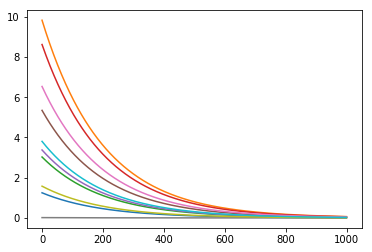

In [12]:
# sanity check: the elements in the diagonal of F are all negative -> each variable is decreased each step, eventually converging to 0
for i in range(10):
    plt.plot([el[i] for el in traj])

## Solvers:

### Goal:

We are trying to approximate the above ODE. One method (which is the same that was used to obtain the above plot) is the Euler's method

### Euler

In [13]:
def eulerSolver(t0, x0, dt, model):
    dxdt = model(x0, dt)
    x0 = x0 + dxdt
    return x0

In [14]:
traj = []
x0 = 10*torch.rand(10)
dt = 0.01
for t in range(1000):
    x_new = eulerSolver(0, x0, dt, model)
    traj.append(x_new)
    x0 = x_new

As expected, this is similar (different random initialization of x0 but oterwise same exponentially decaying behaviour)

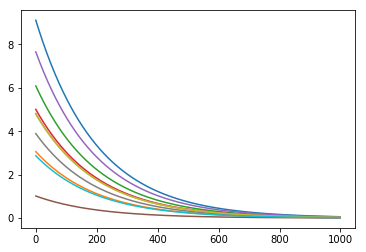

In [15]:
for i in range(10):
    plt.plot([el[i] for el in traj])

### Runge-Kutta 4

In [16]:
def rk4 (t0, x0, dt, model):   
    f1 = model(x0, dt)
    
    c2 = dt * f1 / 2.0
    f2 = model(x0 + c2, dt/2.0)
    
    c3 = dt * f2 / 2.0
    f3 = model(x0 + c3, dt/2.0)
    
    c4 = dt * f3
    f4 = model(x0 + c4, dt)
    
    x0 = x0 + (f1 + 2.0 * f2 + 2.0 * f3 + f4) / 6.0
    return x0

In [17]:
traj = []
x0 = 10*torch.rand(10)
dt = 0.01
for t in range(1000):
    x_new = rk4(0, x0, dt, model)
    traj.append(x_new)
    x0 = x_new

Cool, this works too

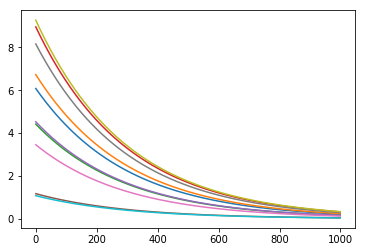

In [18]:
for i in range(10):
    plt.plot([el[i] for el in traj])

# C++ Euler 

Now for the real show:

In [19]:
x_orig = 10*torch.rand(10)

In [20]:
x0 = x_orig
traj1 = []
dt = 0.01
for t in range(1000):
    x_new = eulerSolver(0, x0, dt, model)
    traj1.append(x_new)
    x0 = x_new

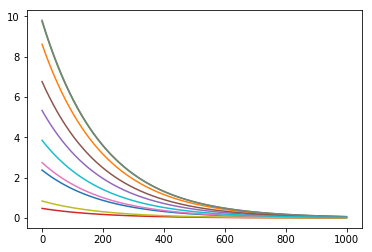

In [21]:
for i in range(10):
    plt.plot([el[i] for el in traj1])

In [25]:
x0 = x_orig
traj2 = []
dt = 0.01
for t in range(1000):
    x_new = pytorchode.odesolver(F, x0, dt, 1, "Euler")
    traj2.append(x_new)
    x0 = x_new

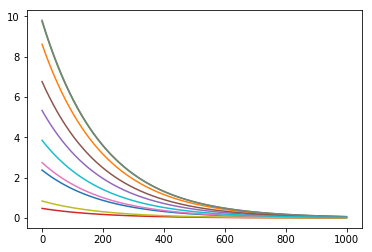

In [26]:
for i in range(10):
    plt.plot([el[i] for el in traj2])

In [27]:
for i in range(len(traj1)):
    delta = traj1[i] - traj2[i]

In [28]:
delta

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# C++ RK4

In [32]:
x_orig = 10*torch.rand(10)

In [33]:
x0 = x_orig
traj1 = []
dt = 0.01
for t in range(1000):
    x_new = rk4(0, x0, dt, model)
    traj1.append(x_new)
    x0 = x_new

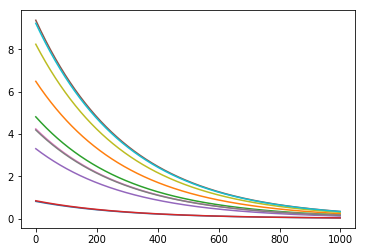

In [34]:
for i in range(10):
    plt.plot([el[i] for el in traj1])

In [35]:
x0 = x_orig
traj2 = []
dt = 0.01
for t in range(1000):
    x_new = pytorchode.odesolver(F, x0, dt, 1, "RK4")
    traj2.append(x_new)
    x0 = x_new

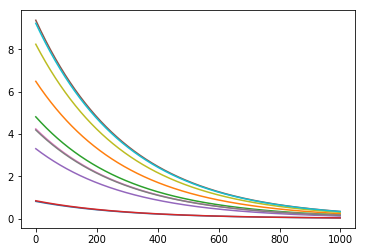

In [36]:
for i in range(10):
    plt.plot([el[i] for el in traj2])

In [37]:
for i in range(len(traj1)):
    delta = traj1[i] - traj2[i]

In [38]:
delta

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

# CUDA Euler

In [7]:
x_orig = 10*torch.rand(10)
x_new = x_orig

In [67]:
%%timeit
x0 = x_orig
traj1 = []
dt = 0.01
for t in range(1000):
    x_new = eulerSolver(0, x0, dt, model)
    traj1.append(x_new)
    x0 = x_new

13.2 ms ± 90.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


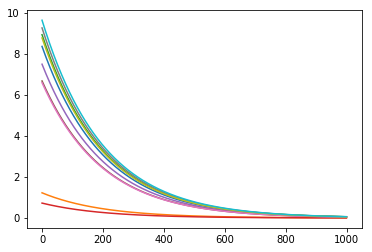

In [68]:
for i in range(10):
    plt.plot([el[i] for el in traj1])

In [47]:
x0 = x_orig.cuda()
F = torch.eye(10)
F = -0.5*F
F = F.cuda()
traj2 = []
dt = 0.1
for t in range(1000):
    x_new = pytorchodecuda.eulerCUDA(F, x0, dt, 100, 10)
    traj2.append(x_new)
    x0 = x_new

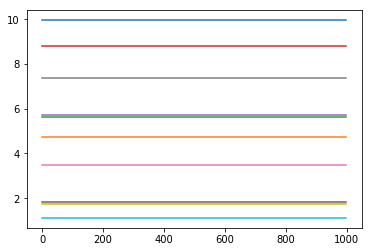

In [48]:
for i in range(10):
    plt.plot([el[i] for el in traj2])

In [52]:
traj2[2]

tensor([9.9540, 4.7423, 5.6524, 8.8081, 5.7031, 1.8133, 3.5003, 7.3659, 1.7232,
        1.1214], device='cuda:0')